<a href="https://colab.research.google.com/github/greyhound101/Orbuculum/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import zipfile
import pandas as pd
import numpy as np
import glob
import os
import cv2
from tqdm import tqdm
import random
import keras.backend as K
from keras.applications import *
from keras.layers import *
from keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [11]:
import keras
import ast
from keras.utils import to_categorical
class DataGenerator(keras.utils.Sequence):
  def __init__(self, series, batch_size=64):
                       # array of labels
    self.paths=[]
    for en,i in enumerate(list(series.index)):
        self.paths+=series[i]
    self.batch_size   = batch_size   
    
  def __len__(self):
    return int(np.floor(len(self.paths) / self.batch_size))


  def __getitem__(self, index):
		# selects indices of data for next batch
    img = [self.paths[k] for k in range(index*self.batch_size,(index+1)*self.batch_size)]
    images=[cv2.imread(path) for path in img]
    labels=[int(path.split('/')[2].split('_')[-1]) for path in img]
    return (np.asarray(images)/255).astype('float32'), to_categorical(labels,43)
    

In [12]:
import tensorflow as tf
from keras.activations import *
class SE(keras.layers.Layer):
    def __init__(self,factor,otr,**kwargs):
        super(SE, self).__init__(**kwargs)
        self.inr=int(otr/factor)
        self.otr=otr
        
    def get_config(self):
        base_config = super(SE, self).get_config()

    def build(self, input_shape):
        super(SE, self).build(input_shape)
        self.pool1=GlobalAveragePooling2D()
        self.compress=Dense(self.inr,activation='relu')
        self.expand=Dense(self.otr,activation='sigmoid')

    def call(self, img):
        y = self.pool1(img)
        y = self.compress(y)
        map = self.expand(y)
        map = tf.expand_dims(map,1)
        map = tf.expand_dims(map,2)
        return tf.math.multiply(img,map)


In [13]:
def load_model(last=True): 
  K.clear_session()   
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(30,30,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=64, kernel_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(SE(4,64))
    
  model.add(Conv2D(filters=32, kernel_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=64, kernel_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(SE(8,64))
    
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))
  return model


In [14]:
model=load_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 64)        0

In [15]:
from keras.optimizers import *
import numpy as np
train=DataGenerator(df['train'])
test=DataGenerator(df['test'])
validation=DataGenerator(df['validation'])

In [16]:
model.compile(optimizer=Adam(1e-3,decay=1e-3),  
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
ln=len(train)
hist=model.fit_generator(train,epochs=50,steps_per_epoch=ln,validation_data=validation)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
367/367 [==============================] - 46s 122ms/step - loss: 3.4624 - accuracy: 0.1417 - val_loss: 2.2092 - val_accuracy: 0.4242
Epoch 2/50
367/367 [==============================] - 44s 121ms/step - loss: 1.6851 - accuracy: 0.5731 - val_loss: 1.0542 - val_accuracy: 0.7564
Epoch 3/50
367/367 [==============================] - 44s 120ms/step - loss: 0.8536 - accuracy: 0.7633 - val_loss: 0.6890 - val_accuracy: 0.8276
Epoch 4/50
367/367 [==============================] - 44s 120ms/step - loss: 0.6006 - accuracy: 0.8265 - val_loss: 0.5186 - val_accuracy: 0.8738
Epoch 5/50
367/367 [==============================] - 44s 120ms/step - loss: 0.3832 - accuracy: 0.8914 - val_loss: 0.4975 - val_accuracy: 0.8772
Epoch 6/50
367/367 [==============================] - 44s 121ms/step - loss: 0.2913 - accuracy: 0.9199 - val_loss: 0.3817 - val_accuracy: 0.9039
Epoch 7/50
367/367 [==============================] - 44s 120ms/step - loss: 0.1945 - accuracy: 0.9455 - val_loss: 0.3494 - val_ac

In [17]:
pre=model.predict(test)
pre=np.argmax(pre,1)
tot=[]
for i in range(len(test)):
    tot.append(test[i][-1].reshape(-1,43))
act=np.stack(tot).reshape(-1,43)
act.shape

(7808, 43)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(pre,np.argmax(act,1))

0.9448002049180327

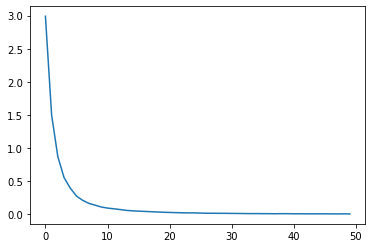

In [19]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])

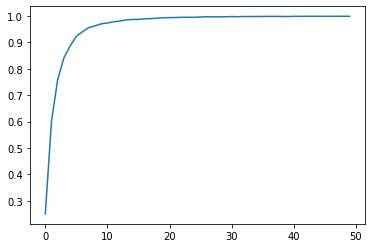

In [20]:
plt.plot(hist.history['accuracy'])

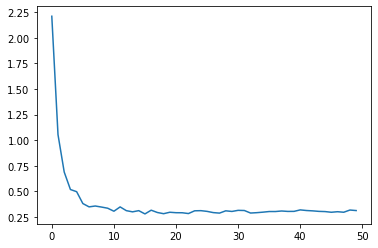

In [21]:
plt.plot(hist.history['val_loss'])

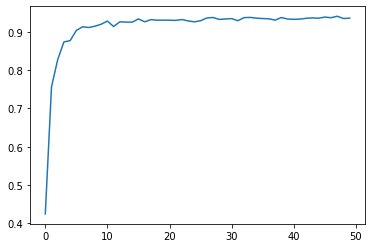

In [22]:
plt.plot(hist.history['val_accuracy'])